# “Go not to the Elves for counsel, for they will say both no and yes.”
-- Frodo Baggins

# Outline

- Brief Pat101

- Introduction to/Context of the problem

- Approach (merits, justification)

- Methods/Code

- Model and its Performance

- Conclusions

![pat101](pat101slide_july2022.PNG)

![pat101_2](pat101_slide2.PNG)

## THE PROBLEM

# SMILES -> L1

Objective: Predict the L1 classification (e.g. 'Enzyme','Transcription Factor','Membrane protein/receptor') of the *protein* (not plural!) that a ligand may bind to, given the ligand's SMILES code.

e.g.
CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1	 -> "Enzyme"

ASSUMPTION: Each ligand binds to only one protein.

# Context of the Problem

Ligand Screening, which may be done for many reasons:

- Reduce number of experiments and examine a *MUCH* larger chemical space

- Identify optimal ligands, i.e., the best N therapeutic candidates 

- Study the commonalities of ligands that do bind; e.g. functional groups

Not possible here given the assumption, but with a few modifications:

- Look for x-specific (e.g. bispecific) ligands

- Identify potential off-target effects, likelihood of side-effects... (with identified optimal ligands, see predicted probability of binding to other classes/proteins)

## THE APPROACH

Given 1,000,000+ SMILES Codes and the *VERY* broad L1 Category (15 classes) ...

Chemical Approach:

- Generate/predict a bunch of chemical features (binding energy possible but not likely valuable in this study)

- Identify useful features from past work: see DeepTox

- Comptuationally intensive - use subset of data during development

- Use ML classification algorithms to predict the SINGLE targets of ea. ligand

Pros: 

- Can analyze specific chemical features in post-analysis

- Reasonably modular/scalable; can add more predicted chemical features, docking results, *and assay results if they exist*

Cons:

- Limited structural information, e.g. 'fingerprint'

- Computationally intensive, at least w. RDKIT and one EC2 instance; w. docking etc. much more intensive

- No assays, all data in-silico

Alternative Structural Approach (EXTREMELY NAIVE):

- One-Hot Encode (i.e. 1/0 if character is A, B, or C) the SMILES codes, as strings

- Based on work that followed up on DeepTox; identified interesting common structural features

Pros:

- Identifies relevant, common structures that *ARE* SMILES codes and can be directly re-input to screen for ligands with that feature

- Arguably easier to implement; no chemical knowledge required, but...

Cons:

- ONLY structural data generated; no further analysis can be done, no other features to analyze

Therefore more of a supplementary model to confirm hits or dig into exact structures of interest.

Citations:

DeepTox:

https://www.frontiersin.org/articles/10.3389/fenvs.2015.00080/full
Mayr, Andreas, et al. "DeepTox: toxicity prediction using deep learning." Frontiers in Environmental Science 3 (2016): 80.

CNN/One-Hot:

https://link.springer.com/article/10.1186/s12859-018-2523-5
Hirohara, Maya, et al. "Convolutional neural network based on SMILES representation of compounds for detecting chemical motif." BMC bioinformatics 19.19 (2018): 83-94.

## Method/Codes

In [1]:
# coding: utf-8
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import sys as sys
import os as os
import ast as ast
from random import sample
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import PandasTools
from rdkit import RDConfig
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import Descriptors as D
from rdkit.Chem import rdMolDescriptors as MD
from xgboost import XGBClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data loading...

In [2]:

# smiles_l1.csv should be in the same directory as the .ipynb

big_df = pd.read_csv("smiles_l1.csv")  # warning: BIG file

# 1 million (Dr.Evil face) samples! let's get 1%; gives 16 classes including 'unknown'
df = big_df.sample(frac=0.05, replace=False, random_state=42)

# alternative if desired to train the model on EVERYTHING:
# df = big_df

df.dropna() #paranoia

# get those lists in the 2nd column resolved; unknown to me still if they're just dup'd
# using ast.literal_eval enables import as a list w one element rather than an entire list
df.L1_class_name = df.L1_class_name.apply(ast.literal_eval)


In [3]:
df.head()

,canonical_smiles,L1_class_name
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme]
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein]
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator]
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme]
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme]


In [4]:

df.describe()

,canonical_smiles,L1_class_name
count,71895,71895
unique,71895,18
top,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme]
freq,1,35117


# Process L1 Class data...

In [5]:
df['string_L1'] = df['L1_class_name'].apply(lambda x: x[0])
df.head()
# so this lambda fn; we set x = the first and only element in L1_class_name; that
# x becomes string_L1 in our new column. 

# pd DEMANDS you declare your factors and get the KEY of what they are
df['Target_Class'], uniques = pd.factorize(df.string_L1)
df.head()

,canonical_smiles,L1_class_name,string_L1,Target_Class
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme],Enzyme,0
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein],Unclassified protein,1
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator],Epigenetic regulator,2
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme],Enzyme,0
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme],Enzyme,0


In [6]:
uniques

Index(['Enzyme', 'Unclassified protein', 'Epigenetic regulator',
       'Membrane receptor', 'Transporter', 'Transcription factor',
       'Ion channel', 'Other membrane protein', 'Other cytosolic protein',
       'Secreted protein', 'Structural protein', 'Other nuclear protein',
       'Surface antigen', 'Adhesion', 'Auxiliary transport protein'],
      dtype='object')

# RDKit Molecules and Descriptors...

,canonical_smiles,L1_class_name,string_L1,Target_Class,ROMol
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme],Enzyme,0,
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein],Unclassified protein,1,
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator],Epigenetic regulator,2,
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme],Enzyme,0,
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme],Enzyme,0,

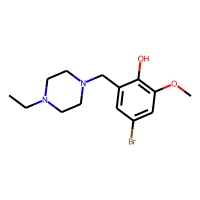
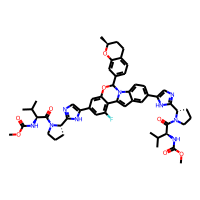
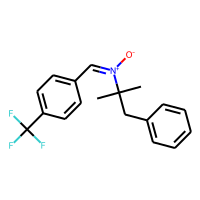
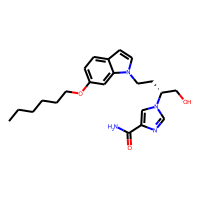
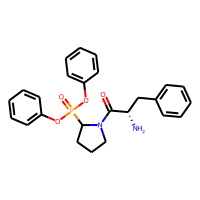

In [7]:
# takes ~ 26 seconds with 1% of data and t3.xlarge
pdt.AddMoleculeColumnToFrame(df, 'canonical_smiles', includeFingerprints=True)
df.head()

# Salt processing...

Salts are relevant here, but there were several molecules that only differed by number of salts; don't wanna bias the data with duplicates so:

In [8]:
# It contains all the salts that I could find (searching through the .csv for .[] etc.) in this dataset
remover = SaltRemover(defnData="[Cl,Br,Zn,Mg,Ca,Sr,Na,K]")

# in this case we don't add a new column, just apply a function to the molecules
df['ROMol'].apply(lambda x: remover.StripMol(x))

df['Cleaned_SMILES'] = df['ROMol'].apply(lambda x: Chem.MolToSmiles(x))

# an alternative method in pandasTools, but not sure how it defines the SaltRemover:
# http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html
# rdkit.Chem.PandasTools.RemoveSaltsFromFrame(frame, molCol='ROMol')


,canonical_smiles,L1_class_name,string_L1,Target_Class,ROMol,Cleaned_SMILES
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein],Unclassified protein,1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator],Epigenetic regulator,2,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...

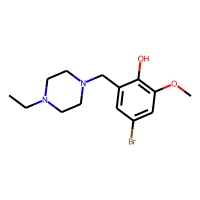
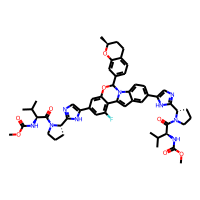
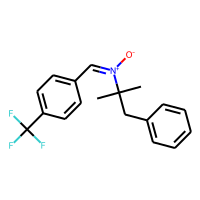
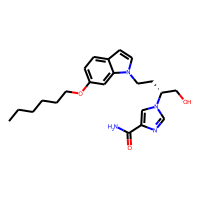
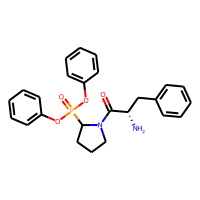

In [9]:
df.head()

In [10]:
# we're gonna get rid of duplicates, let's see original sample #s:
df.describe()

,Target_Class
count,71895.000000
mean,2.029028
std,2.673882
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


In [11]:
# now drop duplicate mols based on cleaned up smiles

# Drop the duplicate mols, keep only the first one; big danger
# that some of the salts may matter... but one of those samples had like
# 20 salts and that's real sus to me
df = df.drop_duplicates(subset='Cleaned_SMILES',keep='first') 
df.describe()

# welp, in this sample we all gucci. w. settings:
# df = big_df.sample(frac=0.01, replace=False, random_state=11)

,Target_Class
count,71895.000000
mean,2.029028
std,2.673882
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


# Feature Generation (finally)

In [12]:
# takes ~30 seconds, 1% data, t3.xlarge

# topological polar surface area for the molecule; 
# poking around the data it seemed there were a number
# of polar phosphate-salt groups, so the S and P option is used
# ... without noticeable effect on end results vs. not including S and P, I'll add
df['TPSA'] = df['ROMol'].apply(lambda x: D.TPSA(x, includeSandP = True))
df['LabuteASA'] = df['ROMol'].apply(lambda x: MD.CalcLabuteASA(x))

# the rest I think require less explanation:
df['MolLogP'] = df['ROMol'].apply(lambda x: D.MolLogP(x))
df['MolWt'] = df['ROMol'].apply(lambda x: D.MolWt(x))
df['MaxPartialCharge'] = df['ROMol'].apply(lambda x: D.MaxPartialCharge(x))
df['MinPartialCharge'] = df['ROMol'].apply(lambda x: D.MinPartialCharge(x))
df['HeavyAtomMolWt'] = df['ROMol'].apply(lambda x: D.HeavyAtomMolWt(x))
# COMES OUT TO 0, SO LEAVE THIS FEATURE O-U-T OUT!
# df['NumRadicalElectrons'] = df['ROMol'].apply(
    # lambda x: D.NumRadicalElectrons(x))
df['NumValenceElectrons'] = df['ROMol'].apply(
    lambda x: D.NumValenceElectrons(x))
df['NumHAcceptors'] = df['ROMol'].apply(lambda x: D.NumHAcceptors(x))
df['NumHDonors'] = df['ROMol'].apply(lambda x: D.NumHDonors(x))
df['NumAromaticRings'] = df['ROMol'].apply(lambda x: D.NumAromaticRings(x))

# ... except for these, which I thought could be interesting;
# Morgan fingerprint, at least my perception, is somewhat analagous to ECFP:
# https://pubs.acs.org/doi/10.1021/ci100050t
# Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." Journal of chemical information and modeling 50.5 (2010): 742-754.
# this exact implementation here in RDKit is... honestly not too clearly documented
# but I thought it'd be interesting to include; the visual implementation is more informative than this number I think

df['FpDensityMorgan1'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan1(x))
df['FpDensityMorgan2'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan2(x))
df['FpDensityMorgan3'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan3(x))

# OG paper:
# https://pubs.acs.org/doi/pdf/10.1021/c160017a018
# 1965!! 
# Morgan, Harry L. "The generation of a unique machine description for chemical structures-a technique developed at chemical abstracts service." Journal of chemical documentation 5.2 (1965): 107-113.

# more LOTR:
# Capecchi, Alice, Daniel Probst, and Jean-Louis Reymond. 
# "One molecular fingerprint to rule them all: drugs, biomolecules, and the metabolome." Journal of cheminformatics 12.1 (2020): 1-15.

# Move Y to the end...

And see data types, sanity check

In [13]:
# I'm more familiar with data wrangling in R so,
# credit to Charlie Haley from this stackoverflow, this operation IMO is easier in R:
# https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe

colNames = df.columns.values
colNames = list(df.columns.values)
colNames.pop(colNames.index('Target_Class'))
df = df[colNames + ['Target_Class']]

# replace any infs, that I'm seeing below, with na; they appear in the charges
# from: https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas
df.replace([np.inf, -np.inf], np.nan, inplace=True) 

df.dropna() # then drop na
np.nan_to_num(df) # if there are somehow any na left, convert to some num
df.dtypes

canonical_smiles        object
L1_class_name           object
string_L1               object
ROMol                   object
Cleaned_SMILES          object
TPSA                   float64
LabuteASA              float64
MolLogP                float64
MolWt                  float64
MaxPartialCharge       float64
MinPartialCharge       float64
HeavyAtomMolWt         float64
NumValenceElectrons      int64
NumHAcceptors            int64
NumHDonors               int64
NumAromaticRings         int64
FpDensityMorgan1       float64
FpDensityMorgan2       float64
FpDensityMorgan3       float64
Target_Class             int64
dtype: object

,canonical_smiles,L1_class_name,string_L1,ROMol,Cleaned_SMILES,TPSA,LabuteASA,MolLogP,MolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomMolWt,NumValenceElectrons,NumHAcceptors,NumHDonors,NumAromaticRings,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,Target_Class
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme],Enzyme,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,35.94,122.640103,2.3008,329.238,0.161813,-0.504030,308.070,106,4,1,1,1.210526,1.842105,2.421053,0
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein],Unclassified protein,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,198.03,410.333502,8.9686,970.116,0.407013,-0.490416,909.636,372,11,4,6,0.732394,1.338028,1.929577,1
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator],Epigenetic regulator,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,26.07,133.028322,4.6559,321.342,0.415910,-0.623397,303.198,122,1,0,2,0.956522,1.521739,2.043478,2
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme],Enzyme,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,95.30,170.651629,3.5195,398.507,0.268389,-0.493520,368.267,156,6,2,3,1.275862,2.137931,2.862069,0
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme],Enzyme,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,91.67,188.045633,4.8560,450.475,0.452637,-0.414718,423.259,166,5,1,3,0.906250,1.406250,1.937500,0

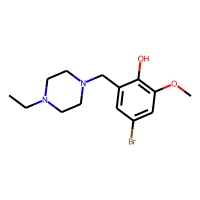
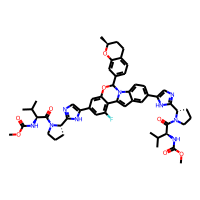
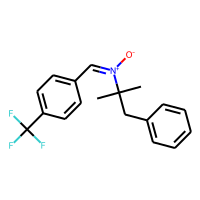
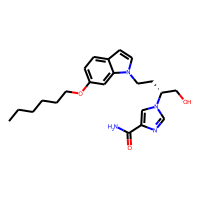
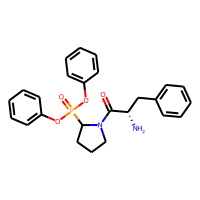

In [14]:
df.head()

In [15]:
df.describe()

# interesting that labute came out lower than TPSA. Just differences in how they calcualted I guess

,TPSA,LabuteASA,MolLogP,MolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomMolWt,NumValenceElectrons,NumHAcceptors,NumHDonors,NumAromaticRings,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,Target_Class
count,71895.000000,71895.000000,71895.000000,71895.000000,71845.000000,71847.000000,71895.000000,71895.000000,71895.000000,71895.000000,71895.000000,71895.000000,71895.000000,71895.000000,71895.000000
mean,103.352925,180.552103,3.315251,434.774787,0.282409,-0.430750,409.645131,160.718868,5.633646,2.008902,2.584950,1.088908,1.802655,2.469341,2.029028
std,116.569921,107.768584,2.306876,265.378499,0.097053,0.085258,247.510926,102.671453,4.261048,3.912883,1.225891,0.205518,0.278394,0.342556,2.673882
min,0.000000,7.504228,-65.884100,17.031000,-1.000000,-1.000000,14.007000,8.000000,0.000000,0.000000,0.000000,0.108696,0.197479,0.296218,0.000000
25%,63.990000,138.708219,2.361510,331.799500,0.235769,-0.492842,312.269000,122.000000,4.000000,1.000000,2.000000,0.970588,1.666667,2.318182,0.000000
50%,86.690000,165.929032,3.424680,398.463000,0.267552,-0.457380,376.290000,146.000000,5.000000,1.000000,3.000000,1.093750,1.833333,2.516129,1.000000
75%,113.300000,196.458109,4.517950,473.577000,0.328860,-0.365523,447.085500,174.000000,7.000000,2.000000,3.000000,1.217391,1.971429,2.687500,3.000000
max,4010.610000,2810.635663,22.673300,7543.898000,2.000000,-0.061629,7269.722000,2590.000000,205.000000,86.000000,34.000000,2.000000,2.700000,3.461538,14.000000


Alright so let's take some notes on what I'm seeing just from this table, decide what to target with graphs:
- TPSA - a minimum of 0??? need to dig into the data and make sure this isn't an error. It is POLAR surface area, and I'd expect a considerable number of nonpolar molecules. Maybe we can just decide on a threshold to consider 'nonpolar' and keep that feature.
- No radical electrons. Remove this feature. Only throws things off.
- MAXIMUM OF 1848 VALENCE ELECTRONS?? Wtf is that molecule??
- Rest looks OK. Again would be preferable to have like assays or maybe even docking results, but w/e. So just TPSA and valence to look at in depth.

------
Let's make sure we got a good handle on the literature/theory:

OG TPSA paper: https://pubmed.ncbi.nlm.nih.gov/11020286/
Ertl, Peter, Bernhard Rohde, and Paul Selzer. "Fast calculation of molecular polar surface area as a sum of fragment-based contributions and its application to the prediction of drug transport properties." Journal of medicinal chemistry 43.20 (2000): 3714-3717.
- "A new approach for the calculation of the PSA is presented here, based on the summation of tabulated surface contributions of polar fragments. "
https://peter-ertl.com/reprints/Ertl-JMC-43-3714-2000.pdf
Literally sees fragments, eg ROH, and looks up a calculated PSA value and just sums 'em up for the molecule. Really nifty. And comes out pretty well, TPSA ~ PSA

(btw: QSAR = quantitative structure-activity relationship... so just what we're doing lol but sounds cool)
A paper discussing TPSA: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7549127/
Prasanna, S., and R. J. Doerksen. "Topological polar surface area: a useful descriptor in 2D-QSAR." Current medicinal chemistry 16.1 (2009): 21-41.
- Basically an approximation, in 2D, of the potential for polar interactions, negating the need for 3D calculations. NOT perfect. The authors note specifically: 
- "The first limitation is the inability of TPSA to capture the activity difference of compounds differing only in their non polar groups... The second limitation stems from the fact that TPSA calculation does not include the influence of positional changes of functional groups. For example, a polar group in ortho, meta or para position or even placed at a different place in the molecule would contribute the same amount to the TPSA."

---

Conclusion: Look for an additional measure of SA in RDKit; don't wanna risk RDKit molecule being incompatible or needing to calc a whole other thing. 

There is labute accessible surface area (ASA);  more inclusive of nonpolar groups, arguably better idea of surface area. Many more descriptors are available, listed here: https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors and here: https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html 
Curiously 'FreeSASA' is an empty module: https://www.rdkit.org/docs/source/rdkit.Chem.rdFreeSASA.html; I found documentation here for how to call it:  https://iwatobipen.wordpress.com/2019/11/07/calculate-free-solvent-accessible-surface-area-rdkit-chemoinformatics/. 

So! Labute. And then we just look at the valence electron distributions, maybe exclude a cluster of weird molecules.

From: https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html

# Alrighty then! Let's get looking at some distributions of the data!

Let's first understand the makeup of the data we're working with, my impression is 'Enzyme' is *VERY* populous in this dataset.

Index(['Enzyme', 'Unclassified protein', 'Epigenetic regulator',
       'Membrane receptor', 'Transporter', 'Transcription factor',
       'Ion channel', 'Other membrane protein', 'Other cytosolic protein',
       'Secreted protein', 'Structural protein', 'Other nuclear protein',
       'Surface antigen', 'Adhesion', 'Auxiliary transport protein'],
      dtype='object')

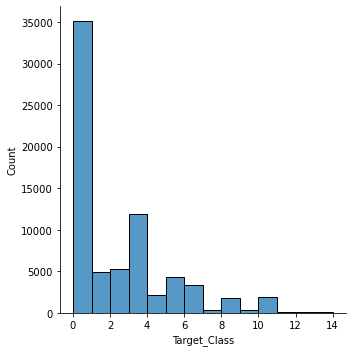

In [16]:
# Gonna do 3 graphs that I think will be informative, hopefully replace the above 2 pandas sad graphs.

# 1. Let's understand the difference in the counts of data coming in.
# use custom bins to avoid nasty open spaces
sns.displot(df, x='Target_Class',bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
uniques

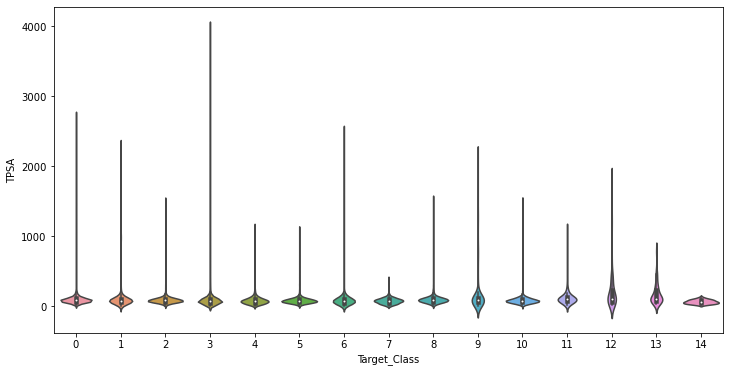

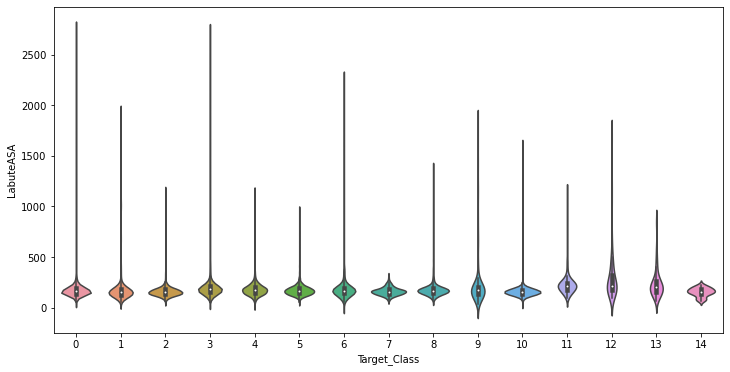

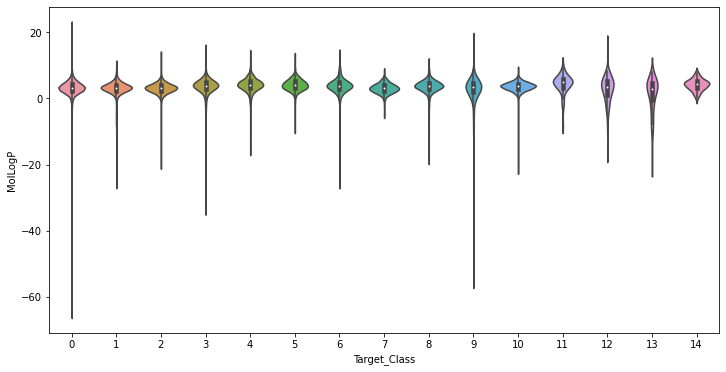

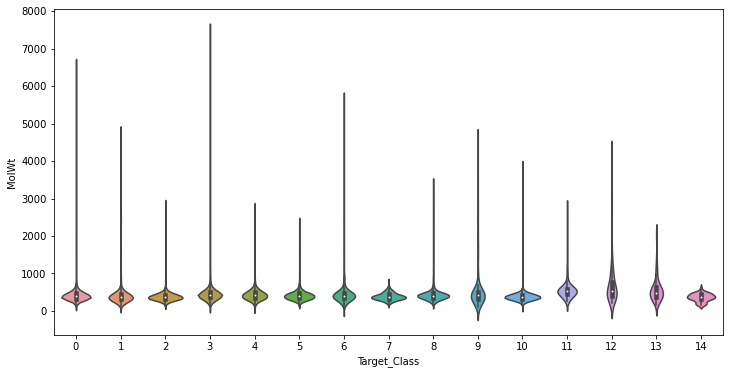

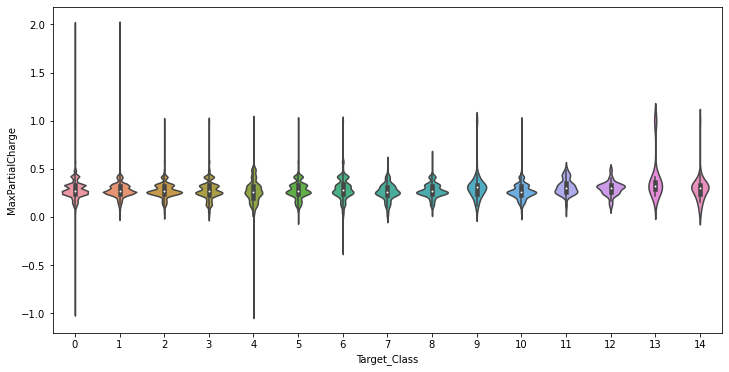

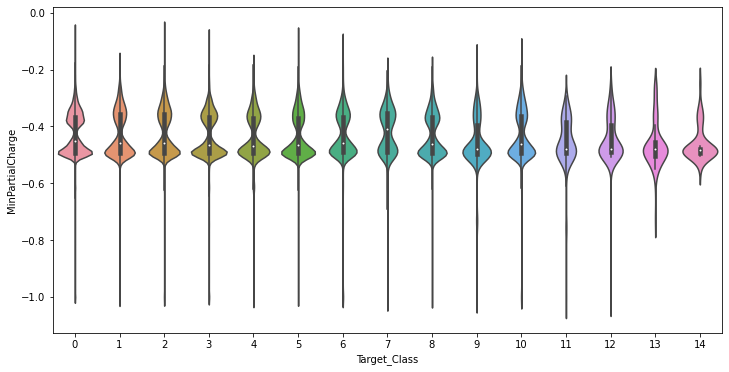

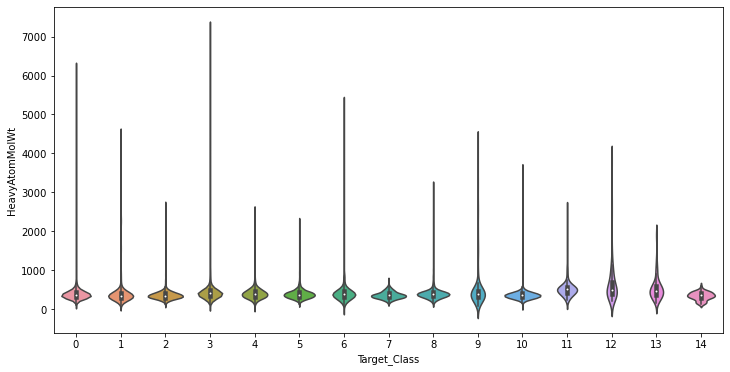

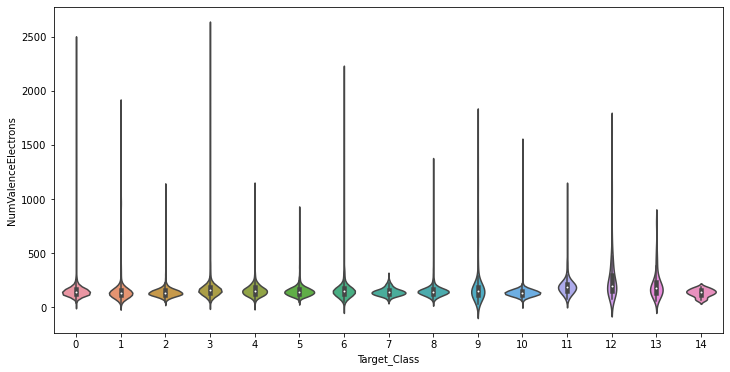

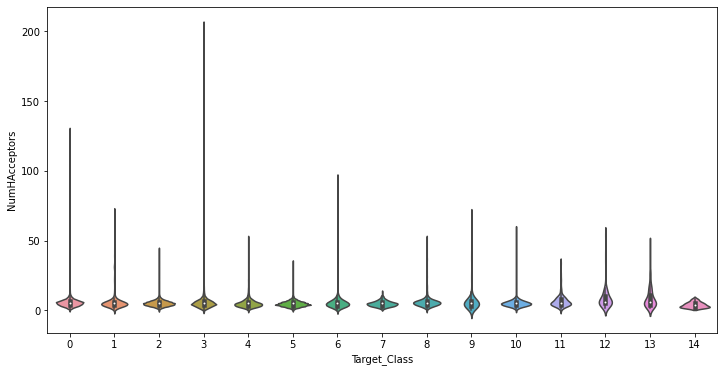

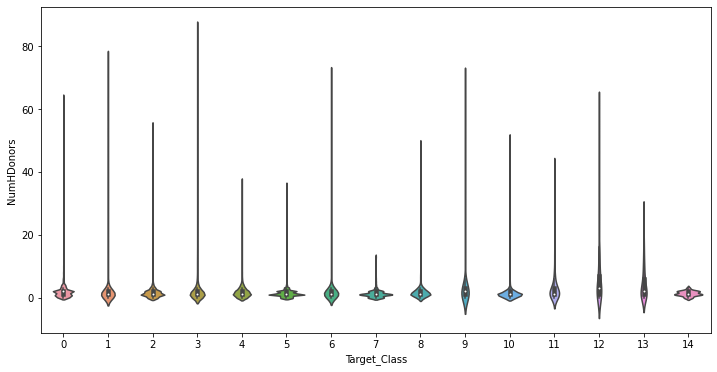

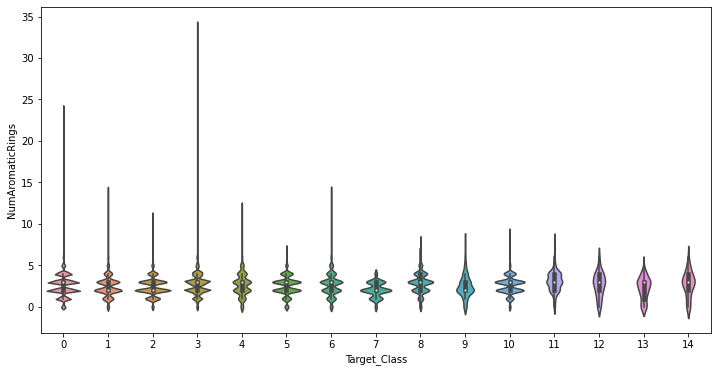

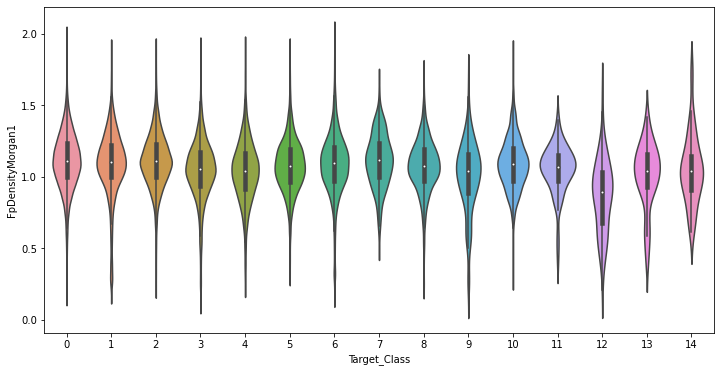

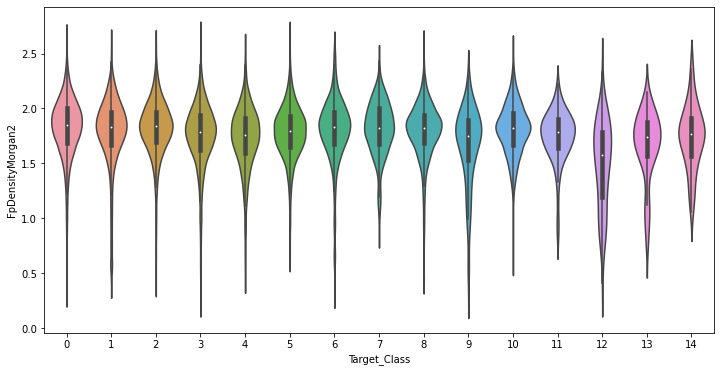

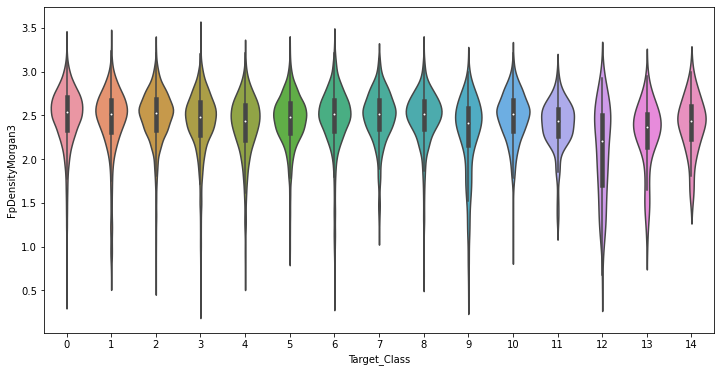

In [17]:
# let's try doing class by properties first, then a bunch of graphs.

# let's define a list of our features...
features = ['TPSA', 'LabuteASA', 'MolLogP', 'MolWt', 'MaxPartialCharge', 'MinPartialCharge', 'HeavyAtomMolWt', 'NumValenceElectrons',
                                                    'NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3']

for i in range(len(features)):
    plt.figure(figsize=(12,6)) # only affects next produced plot, i think
    sns.violinplot(x="Target_Class", y = features[i], data=df)
    plt.show()

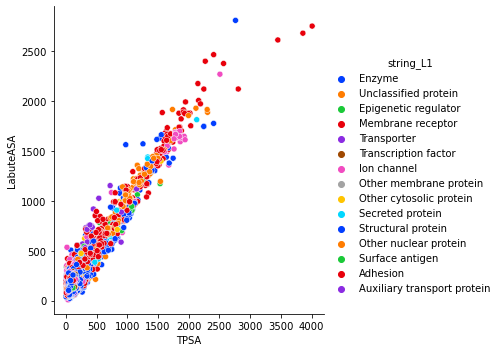

In [18]:

# plt.figure(figsize=(15,10)) # don't seem to work
sns.relplot(x='TPSA',y='LabuteASA',hue="string_L1", palette="bright",data=df)
# uniques        

Ok, so we largely see that these are somewhat interchangeable estimates, but interestingly, we do see lots of red and green, so target class 2 and 3, ion channels and membrane receptors! This also offers us a decent cutoff to examine these really big molecules and have a reasonably small sample to take a manual look at.

So let's try grouping by those samples and make sure they're... informative for our models, not just crackpot molecules.

In [19]:
bigMols = df[df.LabuteASA > 1250]
bigMols.describe()

,TPSA,LabuteASA,MolLogP,MolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomMolWt,NumValenceElectrons,NumHAcceptors,NumHDonors,NumAromaticRings,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,Target_Class
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,1703.436364,1608.680699,-13.417762,3976.419267,0.323006,-0.493265,3707.065631,1534.977273,58.926136,54.642045,6.306818,0.264014,0.541582,0.894676,3.215909
std,412.118010,286.291865,6.604381,766.893836,0.060382,0.036673,738.409755,268.008272,23.511218,9.570326,5.155542,0.052615,0.117630,0.197768,2.285101
min,973.770000,1252.602683,-54.021000,3031.700000,0.243144,-0.747935,2797.844000,1198.000000,31.000000,28.000000,0.000000,0.109244,0.197479,0.296218,0.000000
25%,1458.165000,1407.812338,-16.257770,3455.998000,0.305481,-0.507967,3210.975500,1347.000000,48.000000,49.000000,4.000000,0.222664,0.453304,0.761638,1.000000
50%,1616.165000,1567.967628,-13.749825,3871.459000,0.305481,-0.507967,3589.411500,1507.000000,53.000000,54.000000,6.000000,0.267284,0.550194,0.912795,3.000000
75%,1843.620000,1691.005693,-10.255548,4172.280500,0.325978,-0.481229,3889.805750,1614.000000,61.250000,61.000000,7.000000,0.302539,0.625659,1.028839,3.000000
max,4010.610000,2810.635663,12.446640,7543.898000,1.000000,-0.367888,7269.722000,2590.000000,205.000000,86.000000,34.000000,0.390909,0.896396,1.459459,12.000000


/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


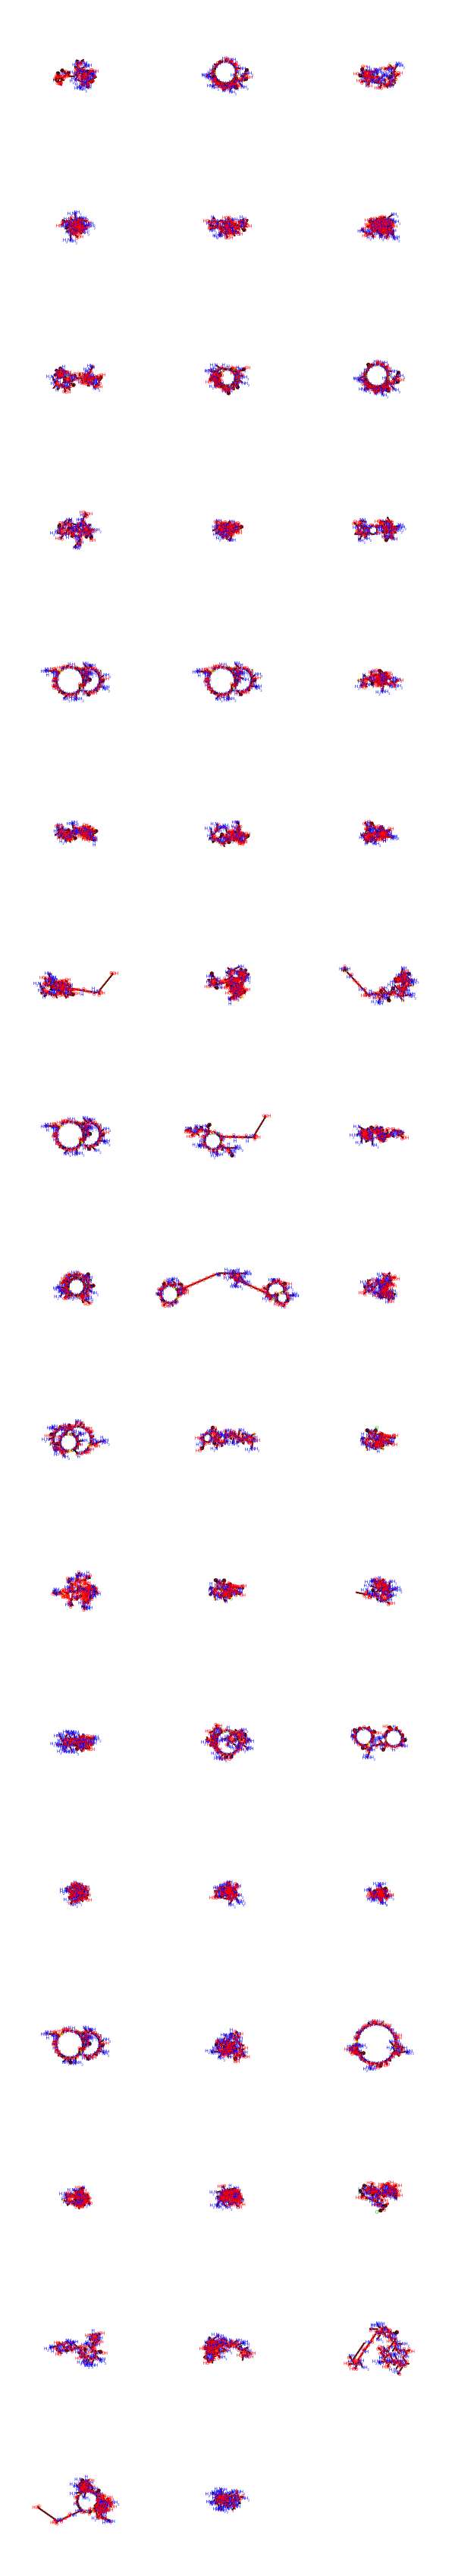

In [20]:
# WELL. In 1% of the data, like 10k samples, we get 23, TWENTY-THREE big molecules. 
# in 2%, we get 76

pdt.FrameToGridImage(bigMols)


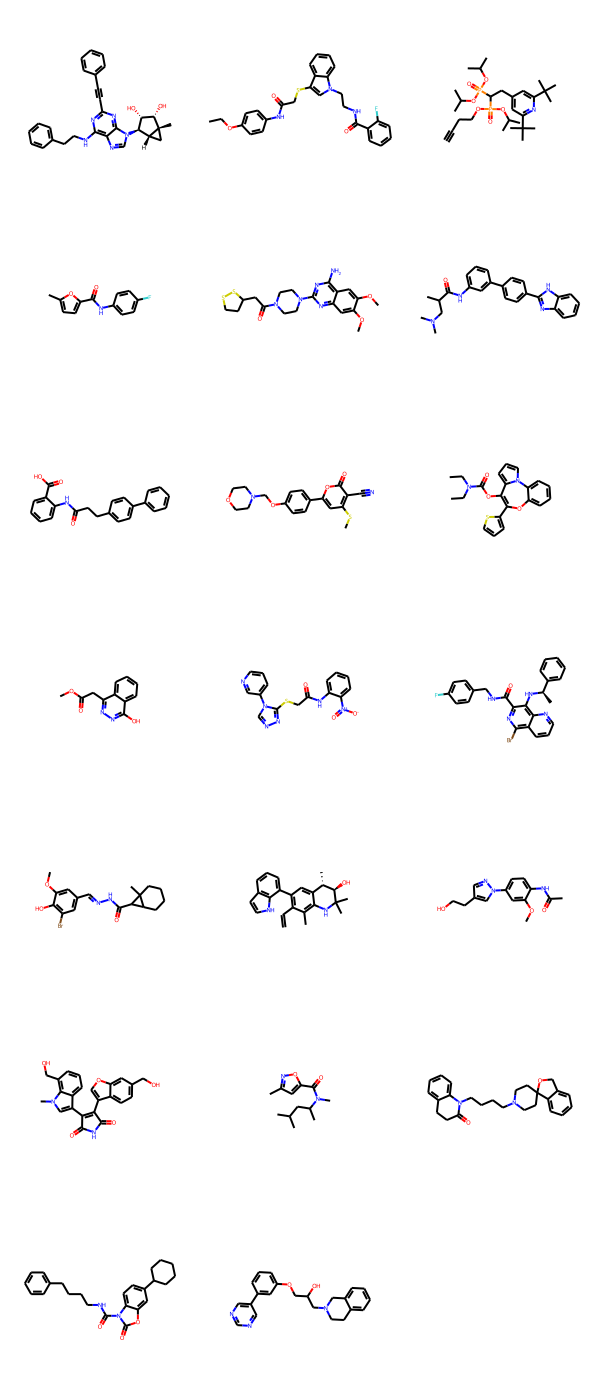

In [21]:
# let's also look at a random assortment of molecules, make sure not everything is nuts:
rand_df = df.sample(n = 20, replace=False, random_state=42)
rand_df.describe()
pdt.FrameToGridImage(rand_df)


In [22]:
# noExtremesdf = df[df.LabuteASA < 500] # tried with <1250 also
# for i in range(len(features)):
#     sns.violinplot(x="Target_Class", y = features[i], data=noExtremesdf)
#     plt.show()

Ehhhh not clear there's an improvement in the shape of distributions -- just fewer extremes, I'll save this as an option during training, maybe just take the best ML and try again with less extremes. My suspicion is that eliminating data willy-nilly etc. is not a good move. But this is interesting.

One last thing, let's get the correlation of different features with each other, code is pretty straightforward:

<AxesSubplot:>

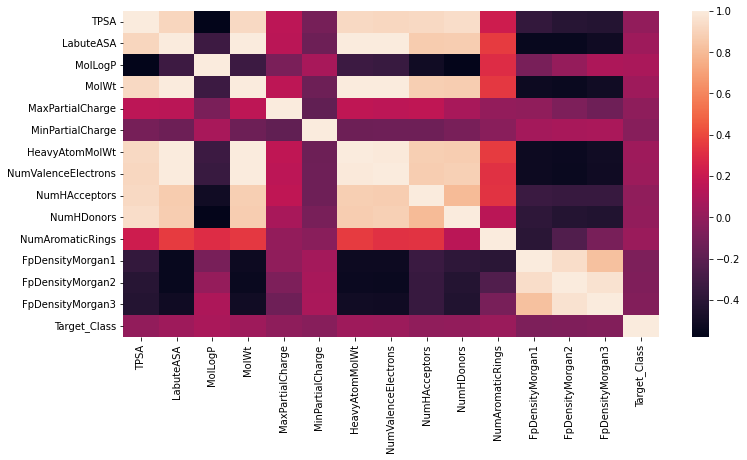

In [23]:
# One more graph, the correlations of all these features w... ea. other.
plt.figure(figsize=(12,6))
sns.heatmap(df.corr())

So -- let's look at correlations with Target Class ... pretty much ~0. So that's uh... not awesome. The morgan fingerprints are all pretty close to each other, maybe we'd get away with just fpdensity1. MolWt correlates with surface area and numbers of electrons, donors, etc.

This does provide a nice interpretation of morgan density; negatively correlated with larger molecules. Aromatic rings correlated with other things that serve as a measure of the size of the molecule.

Let's remember MolLogP is effectively preference for polar (lower logP value) and nonpolar (higher logP) environmnents. Negatively correlated with more hydrogen donors/acceptors, polar groups, which is correct, and also with surface areas, more solvent accessible, so that also... mostly checks out. Positively with aromatic rings, so that's cool.

But yeah. *VERY* poor correlation with Target Class. So let's go through grid search, but I'm thinking no on implementing any PyTorch stuff.

# Split the data:

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df[features], df.Target_Class, test_size=0.2, random_state=1)


Note random state = 1 is specified above, so I can discuss the results with confidence they're the same... although getting different data (from sampling df from big_df above) didn't seem to make much difference anyway.

Now, scale/normalize our data:

# Normalize data:

In [25]:
# there's some really nice documentation on pipelines in python using scikit,
# but imo stil not as nice as R w. pipe operators
# https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

sc = StandardScaler() # from sci-kit
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test) # use same fit as w. training

# and not appropriate to transform the Y data

I favor XGBoost for multiclassification problems; I did some hyperparameter tuning off-screen to... no noticeable difference, so, mostly/all defaults:

# Parameter definition/setup:

In [26]:
df.Target_Class.describe() 
# max of 14, i.e. 0 - > 14 therefore 15 classes

count    71895.000000
mean         2.029028
std          2.673882
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         14.000000
Name: Target_Class, dtype: float64

In [27]:
# when using .fit method, the DMatrix conversion is not required:
x_train_xg = xgb.DMatrix(x_train, label=y_train)
x_test_xg = xgb.DMatrix(x_test,  label=y_test)
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# from XGBoost website: "DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed"

params = {} # initialize

# these two will not be changed:

# for classification, using softmax
# multi:softprob can also be used, outputs all probabilities
# would therefore be useful in, for example, off-target studies
params['objective'] = 'multi:softmax' 
params['num_class'] = 15 # 0 - 14 indeces for the L1 classes

# search for these bad boys:
# GONNA USE BELOW!
# params ={
#     'eta':[0.1,0.3],
#     'max_depth':[6,8], # mucho potential for overfit, but may help!
#     'scale_pos_weight':[float(1),float(100),float(1000)]
#  }

epochs = 50  # seems to work best, 1000 didn't improve accuracy 

# to see evolution of the model:
watchlist = [(x_train_xg, 'train'), (x_test_xg, 'test')]


params['eta'] = 0.3  # DEFAULT 0.3; aka learning_rate
params['max_depth'] = 6  # DEFAULT 6

# unused, appropriate for logistic, not multi-class
# params['scale_pos_weight'] = 1 # default 1 so let's see , # i think??

In [28]:
# AND LET'S GET SOME WEIGHTS PER CLASS, SEE IF THAT HELPS.

# uniques
# np.unique(df['Target_Class'])

# xgboost demands sampleWeights; feature_weights may be == classweights but not sure exactly
# classWeights = skWeights.compute_class_weight(class_weight='balanced',classes=np.unique(df['Target_Class']),y=df['Target_Class'])
# sampleWeights = skWeights.compute_sample_weight(class_weight='balanced',y=df['Target_Class'])


And now for our model!!...

# MODELING!

In [29]:
# THE MAGIC!!!!!!

# BEGIN HYPERPARAM OPTIMIZATION ----------------

# This takes ~30 mins with 2% of data
# poor improvement. like 51% v. 48% rip; 46% w. plain fit method

# griddyXG = GridSearchCV(XGBClassifier(),
#                         params,
#                         cv = 5, #5-fold cross-val
#                         )

# griddyXG.fit(x_train, y_train)
# print("Best score from grid search:")
# griddyXG.best_score_
# print("The winning parameters:")
# griddyXG.best_params_

# # use this to predict stuff:
# bestXG = griddyXG.best_estimator_

# pred = bestXG.predict(x_test) # hopefully works

# END ------------------------------

# train method does not support sample weights :(
model = xgb.train(params, x_train_xg, epochs, watchlist)

pred = model.predict(x_test_xg)

# get performance (based on xgboost github)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Overall error using softmax = {}'.format(error_rate))


[08:22:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:2.15312	test-mlogloss:2.16509
[1]	train-mlogloss:1.96917	test-mlogloss:1.98854
[2]	train-mlogloss:1.84965	test-mlogloss:1.87716
[3]	train-mlogloss:1.76331	test-mlogloss:1.79934
[4]	train-mlogloss:1.69768	test-mlogloss:1.74162
[5]	train-mlogloss:1.64694	test-mlogloss:1.69792
[6]	train-mlogloss:1.60664	test-mlogloss:1.66520
[7]	train-mlogloss:1.57250	test-mlogloss:1.63867
[8]	train-mlogloss:1.54373	test-mlogloss:1.61667
[9]	train-mlogloss:1.51796	test-mlogloss:1.59901
[10]	train-mlogloss:1.49559	test-mlogloss:1.58383
[11]	train-mlogloss:1.47583	test-mlogloss:1.57120
[12]	train-mlogloss:1.46035	test-mlogloss:1.56147
[13]	train-mlogloss:1.44422	test-ml

In [30]:
model.best_iteration

49

In [31]:

## ------ extraneous sample stuff

# attempted with sample weights to no clear improvement:
# 
# classy = XGBClassifier() 
# from https://xgboost.readthedocs.io/en/stable/python/python_api.html
# ctrl+f for 'sample_weights' and 'feature_weights'
# i think scikit sample weights -> same, and class_weights -> feature_weights
# can fit two models and see what the diff is, I anticipate none
# .fit also does not require DMatrix conversion :]
#model = xgb.fit(x_train, y_train)#, params)#, watchlist),# sample_weight = sampleWeights)#, feature_weights=classWeights)
# model = classy.fit(X = x_train,
#                    y = y_train)
#                    #sample_weight = skWeights.compute_sample_weight(class_weight='balanced',y=df.Target_Class))


In [32]:
# print("Best score from grid search:")
# griddyXG.best_score_ #0.51899... so the same as defaults LOL

# print("The winning parameters:")
# griddyXG.best_params_
# {'eta': 0.1, 'max_depth': 8, 'scale_pos_weight': 1.0}
# would increase computational time significantly for no real gain... using defaults

# # use this to predict stuff:
# bestXG = griddyXG.best_estimator_


# XGBoost Performance

In [33]:
print('XGB Classification Report...')
print(classification_report(y_test,pred))
print(uniques) # this is the key

XGB Classification Report...
              precision    recall  f1-score   support

           0       0.54      0.94      0.68      7066
           1       0.59      0.05      0.09       995
           2       0.50      0.02      0.03      1067
           3       0.51      0.31      0.39      2393
           4       0.64      0.10      0.18       414
           5       0.56      0.08      0.15       836
           6       0.75      0.11      0.20       664
           7       0.33      0.01      0.02        84
           8       0.45      0.01      0.03       379
           9       0.83      0.08      0.14        63
          10       0.67      0.03      0.06       346
          11       0.67      0.07      0.13        28
          12       1.00      0.05      0.09        21
          13       1.00      0.06      0.12        16
          14       0.67      0.29      0.40         7

    accuracy                           0.54     14379
   macro avg       0.65      0.15      0.18     143

Ok so:
- Support: # of samples of that class in this dataset, xtrain
- Precision: Actual true positives out of those predicted positives
- Recall: Amount of positives that were predicted by the model, for good or ill; this demonstrates overfit to enzyme, and changing the pos_weight like I thought might help... didn't. Just too many in the dataset and not a viable path to just take equal samples of everything, too many samples lost. Will try with all data instead
- F1 score; a composite of precision and recall; 1.0 is good, 0 is bad; weighted avg most representative of the model's performance. So... uh, bad.




"I'm not angry, just disappointed." Is how I'd describe how I feel about those results. To discuss a little:
'support' details the number of samples of that class, e.g. there were 1326 actual enzyme samples that were fed into the model; of those predictions to be enzymes, half of the predictions were correct; 90% of the enzyme predictions that did occur were good; but, looking at the rest of the data, one can surmise that the model was overfitted to enzymes; they are the vast majority of this sample of the dataset, so it checks out.

I also test a Naive Bayes below, which actually performs even worse; this shows XG is doing better here, but it may be due to overfitting. Either way, not a success; but I'm getting ahead of myself.

# Try with Naive-Bayes

In [34]:

# the sklearn split method is somehow introducing problems

x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

# VERY STRANGE! BUT PREVENTS BELOW FROM EXPERIENCING HORRIBLE ERRORS

modelGNB = GaussianNB()
modelGNB.fit(x_train, y_train)

gnb_pred = modelGNB.predict(x_test)
print("GNB overall accuracy:")
print(metrics.accuracy_score(y_test, gnb_pred))
print("GNB Classification Report...")
print(classification_report(y_test,gnb_pred))

GNB overall accuracy:
0.2964740246192364
GNB Classification Report...
              precision    recall  f1-score   support

           0       0.56      0.50      0.53      7066
           1       0.00      0.00      0.00       995
           2       0.10      0.20      0.14      1067
           3       0.22      0.03      0.05      2393
           4       0.10      0.05      0.06       414
           5       0.08      0.45      0.14       836
           6       0.00      0.00      0.00       664
           7       0.02      0.04      0.03        84
           8       0.00      0.00      0.00       379
           9       0.07      0.02      0.03        63
          10       0.04      0.00      0.01       346
          11       0.02      0.04      0.03        28
          12       0.01      0.19      0.03        21
          13       0.03      0.12      0.05        16
          14       0.00      0.00      0.00         7

    accuracy                           0.30     14379
   macro a

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

--------------------------------------------
# WELL THAT SUCKS. 

# DRAMATIC ENTRANCE MUSIC

In [35]:
# let's reset x_train/x_test, not having the standard scaling, LDA kinda does it by itself
x_train, x_test, y_train, y_test = train_test_split(df[features], df.Target_Class, test_size=0.2, random_state=1)
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# LDA IS MDS BUT MAXIMIZES SEPARABILITY OF CLASSES BASED ON DATA;
# PRODUCES NEW FEATURES THAT MAY THEN BE FED INTO OUR PREDICTIVE MODELS...

# from sklearn:
# will produce <= min(n_classes - 1, n_features), per sklearn, same # here... not sure it's... hmm.
LDA = LinearDiscriminantAnalysis() # defaults good; store_covariance = True may be useful for covariance within class
X_LDA_train = LDA.fit_transform(x_train,y_train)

# 'transform' method by itself is funky
# pd.DataFrame(X_LDA_train) # comes from normalized x_train data; lda math means scaling performed regardless, ok with pre-scaled i think

X_LDA_test = LDA.transform(x_test)

In [37]:
# pd.DataFrame(x_train) # also 0->13; 

In [38]:
LDA.explained_variance_ratio_
# output: top 3 are .44 and ~.2 and ~.12; so LDA comp 1 and 2 explain like 62% variance! wowz
# KEEP ALL OF 'EM FOR NOW


array([4.87952323e-01, 1.75948967e-01, 1.36720410e-01, 7.98277337e-02,
       4.50039185e-02, 2.97141307e-02, 1.64440524e-02, 1.57392395e-02,
       7.26736576e-03, 3.06717736e-03, 1.40680889e-03, 7.00065969e-04,
       2.01696423e-04, 6.11106539e-06])

In [39]:
lda_pred = LDA.predict(X_LDA_test)
error_rate = np.sum(lda_pred != y_test) / y_test.shape[0]
# uhhhh ok, just making sure it does have the right classes!
print(error_rate)
# COOL.

0.9584115724320189


# Now let's redo XGBoost...

In [40]:
X_LDA_train_XG = xgb.DMatrix(X_LDA_train, label=y_train)
X_LDA_test_XG = xgb.DMatrix(X_LDA_test,  label=y_test)

newWatchList = watchlist = [(X_LDA_train_XG, 'train'), (X_LDA_test_XG, 'test')]

In [41]:
# pd.DataFrame(X_LDA_train)

In [42]:
newXG = xgb.train(params, X_LDA_train_XG, epochs, newWatchList) # otherwise same params/epochs as before!

pred = newXG.predict(X_LDA_test_XG)

# get performance (based on xgboost github)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Overall error using softmax = {}'.format(error_rate))

[08:22:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:2.16518	test-mlogloss:2.17839
[1]	train-mlogloss:1.97937	test-mlogloss:2.00396
[2]	train-mlogloss:1.85939	test-mlogloss:1.89525
[3]	train-mlogloss:1.77274	test-mlogloss:1.81901
[4]	train-mlogloss:1.70862	test-mlogloss:1.76516
[5]	train-mlogloss:1.65786	test-mlogloss:1.72398
[6]	train-mlogloss:1.61798	test-mlogloss:1.69293
[7]	train-mlogloss:1.58197	test-mlogloss:1.66777
[8]	train-mlogloss:1.55304	test-mlogloss:1.64776
[9]	train-mlogloss:1.52771	test-mlogloss:1.63197
[10]	train-mlogloss:1.50581	test-mlogloss:1.61882
[11]	train-mlogloss:1.48629	test-mlogloss:1.60789
[12]	train-mlogloss:1.46973	test-mlogloss:1.59961
[13]	train-mlogloss:1.45528	test-ml

In [43]:
print('XGB Classification Report...')
print(classification_report(y_test,pred))
print(uniques) # this is the key

XGB Classification Report...
              precision    recall  f1-score   support

           0       0.53      0.94      0.67      7066
           1       0.70      0.03      0.06       995
           2       0.44      0.00      0.01      1067
           3       0.46      0.29      0.36      2393
           4       0.45      0.04      0.08       414
           5       0.54      0.04      0.07       836
           6       0.62      0.07      0.12       664
           7       0.00      0.00      0.00        84
           8       0.17      0.00      0.01       379
           9       0.00      0.00      0.00        63
          10       0.50      0.01      0.02       346
          11       0.67      0.07      0.13        28
          12       0.50      0.05      0.09        21
          13       0.33      0.06      0.11        16
          14       0.00      0.00      0.00         7

    accuracy                           0.52     14379
   macro avg       0.39      0.11      0.11     143

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

# Desparately, hopelessly, also try the GNB algorithm again...

In [44]:
modelGNB = GaussianNB()
modelGNB.fit(X_LDA_train, y_train)

gnb_pred = modelGNB.predict(X_LDA_test)
print("GNB overall accuracy:")
print(metrics.accuracy_score(y_test, gnb_pred))
print("GNB Classification Report...")
print(classification_report(y_test,gnb_pred))

GNB overall accuracy:
0.47325961471590516
GNB Classification Report...
              precision    recall  f1-score   support

           0       0.50      0.94      0.65      7066
           1       0.00      0.00      0.00       995
           2       0.12      0.00      0.00      1067
           3       0.30      0.07      0.11      2393
           4       0.17      0.01      0.03       414
           5       1.00      0.00      0.00       836
           6       0.11      0.00      0.01       664
           7       0.00      0.00      0.00        84
           8       0.00      0.00      0.00       379
           9       0.01      0.06      0.02        63
          10       0.00      0.00      0.00       346
          11       0.25      0.04      0.06        28
          12       0.06      0.05      0.05        21
          13       0.04      0.25      0.07        16
          14       0.00      0.00      0.00         7

    accuracy                           0.47     14379
   macro 

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

# Summarizing...

- We started with SMILES codes for ONE MILLION+ molecules and took a small subset


- Converted those SMILES codes to RDKit Molecule objects; removed salts/duplicates


- Generated several chemical properties (IN SILICO PREDICTION)


- Examined their distributions and correlations with target classes


- Fit a model to the data (using parameters prev. determined as optimal)


- Evaluated the saddening model performance

# Conclusions

- One can do A LOT with just a SMILES code

- Data predicted/generated is INSUFFICIENT to predict L1 class of proteins ligands will associate to

- The chemical space is VAST and it is VERY difficult to make any generalizations/predictions about a ligand and what all it may bind to, without any additional information


# Future Work

- Dock predicted 3d structures with representative proteins per class; requires more specific/narrow study objectives

    - e.g. AutoDock Vina, --score-only --autobox option, for data subsets

- Could look at multiple targets (raw predicted probabilities per class, SoftMax -> SoftProb)


- Integrate assay data

    - PubChem RESTAPI + Web Scraping
    - SMILES -> CID; CID -> Bioassay results

- Cross reference with structural data/alternative approach

# That's all Folks!